In [1]:
from matplotlib import pylab as plt
from matplotlib import colors
import numpy as np
import math
from itertools import product

#Создание трапециеидальной функции
def triangle_FS (U, a=None, b=None, c=None, d=None, h=1, form='equal'):
    if form in ['equal', 'greater', 'less']:
        if a is None:
            a = U.min()
        if d is None:
            d = U.max()
        if b is None:
            if c is None:
                b=(a+d)/2.
            else:
                b=c
        if c is None:
            c=b
        Mu=dict()
        if a>U.min():
            for el in U[U<=a]:
                Mu[el] = h if form=='less' else 0.
        if d<U.max():
            for el in U[U >= d]:
                r=h if form == 'greater' else 0.
                z=Mu.get(el,0)
                Mu[el] = r if r>z else z
        if a<b:
            for el in U[(U>=a)*(U<=b)]:
                r=0. if form == 'greater' else h*float(el-a)/(b-a) if form == 'equal' else h*float(b-el)/(b-a)
                z=Mu.get(el,0)
                Mu[el] = r if r>z else z
        if b<c:
            for el in U[(U >= b)*(U <= c)]:
                r = h if form == 'equal' else 0.
                z = Mu.get(el, 0)
                Mu[el] = r if r > z else z
        if c<d:
            for el in U[(U>=c)*(U<=d)]:
                r=0. if form == 'less' else h*float(el-c)/(d-c) if form == 'greater' else h*float(d-el)/(d-c)
                z=Mu.get(el,0)
                Mu[el] = r if r>z else z
        return Mu
    else:
        print('Unknown form')
        return None

# Создание графика по этой функции    
def FS_plot(FS, colors=colors.cnames.keys(), labels = None, title=None, name=None):
    for idx, el in enumerate(FS):
        mas = np.array (sorted(el.items(), key=lambda x: x[0])).T
        if (labels is None):
            lab = ' '
        else:
            lab=labels[idx]
        #plt.plot(mas[0], mas[1], color=list(colors)[idx], label=lab)
        my_colors = ['purple', 'pink', 'green', 'blue', 'red', 'brown', 'black', 'magenta', 'yellow'];
        plt.plot(mas[0], mas[1], color=(my_colors[idx]), label=lab)
    if not (labels is None):
        plt.legend(loc = 'best')
    if not (title is None):
        plt.title (title)
    if not (name is None):
        plt.savefig(name+'.png', format='png', dpi=100)
    plt.show()

In [2]:
#операции с множествами
def F_And (FV, method='minmax'):
    if method=='minmax':
        return np.min(FV)
    elif method=='probability':
        return np.product(FV)
    else:
        print ('Неизвестный метод ', method)
        return None

def F_Or(FV, method='minmax'):
    if method=='minmax':
        return np.max(FV)
    elif method=='probability':
        mu=0
        for el in FV:
            mu=mu+el - mu*el
        return mu
    else:
        print ('Неизвестный метод ', method)
        return None

def F_Not(V1):
    return 1-V1


def alpha_srez (FS, alpha=0.5):
    alph=1e-10 if alpha==0. else alpha
    mas = np.array(list(FS.items())).T
    #print (FS.items())
    return set(mas[0][mas[1]>=alph])

def FS_moment (FS, centr=None):
    mas = np.array(list(FS.items())).T
    if centr is None:
        Cntr_g=np.sum(mas[0]*mas[1])/np.sum(mas[1])
    else:
        Cntr_g=centr
    return np.sum(mas[1]*np.square(mas[0]-Cntr_g))

def FS_describe(FS, method='minmax', verbose='True'):
    mas=np.array(list(FS.items())).T
    h=np.max(mas[1])
    N = np.sum(mas[1]>0)
    Min_el = np.min(mas[0][mas[1] > 0])
    Max_el = np.max(mas[0][mas[1] > 0])
    Fst_max = np.min(mas[0][mas[1]==h])
    Lst_max = np.max(mas[0][mas[1]==h])
    Cntr_max = mas[0][mas[1] == h].mean()
    Cntr_grav = np.sum(mas[0]*mas[1])/np.sum(mas[1])
    Mmnt_in=FS_moment(FS)
    R1=-np.sum([0 if x==0 else x*np.log2(x) for x in mas[1]])
    R1n = (2.*R1)/len(mas[1])
    R2 = 2./len(mas[1])*np.sum([F_And([x, F_Not(x)], method=method) for x in mas[1]])
    R3 = 2./np.sqrt(len(mas[1]))*np.sqrt(np.sum([F_And([x, F_Not(x)], method=method)**2 for x in mas[1]]))
    if verbose:
        print ('Высота= ', h)
        print('Мощность= ', N)
        print('Диапазон значений: ', (Min_el, Max_el))
        print('Максимумы: ', (Fst_max, Cntr_max, Lst_max))
        print('Центр тяжести= ', Cntr_grav)
        print('Момент инерции= ', Mmnt_in)
        print('Размытость: ')
        print('Энтропийная мера= ', (R1, R1n))
        print('Альтернатива 1 (линейная)= ', R2)
        print('Альтернатива 2 (квадратичная)= ', R3)
    return (h, N, (Min_el, Max_el), (Fst_max, Cntr_max, Lst_max), Cntr_grav, Mmnt_in, ((R1, R1n), R2, R3))


def FS_quantificator(FS, quantificators=[u'очень']):
    mas=np.array(list(FS.items())).T
    for el in np.flip(quantificators, axis=0):
        if el==u'очень':
            mas[1]=np.square(mas[1])
        elif el==u'наверное':
            mas[1] = np.sqrt(mas[1])
        elif el == u'не':
            mas[1] = 1-mas[1]
        else:
            print('Неизвестный квантификатор ', el, '. Должно быть очень, наверное или не')
    return dict(mas.T)

In [3]:
# объединение, пересечение, разность, отсечение и арифметические операции
def FS_union (FSs, Ps=None, method='minmax'):
    U=set()
    for FS in FSs:
        U=set.union(U, FS.keys())
    res=dict()
    for el in U:
        s_mu=[]
        for idx, FS in enumerate (FSs):
            p= 1 if Ps is None else Ps[idx]
            s_mu.append(F_And([p, FS.get(el, 0)], method=method))
        res[el] = F_Or(s_mu, method=method)
    return res

def FS_intersection (FSs, Ps=None, method='minmax'):
    U=set()
    for FS in FSs:
        U=set.union(U, FS.keys())
    res=dict()
    for el in U:
        s_mu=[]
        for idx, FS in enumerate (FSs):
            p= 1 if Ps is None else Ps[idx]
            s_mu.append(F_And([p, FS.get(el, 0)], method=method))
        res[el] = F_And(s_mu, method=method)
    return res

#разность 
def FS_difference(FS1, FS2):
    U=set.union(set(FS1.keys()), FS2.keys())
    res=dict()
    for el in U:
        mu1=FS1.get(el,0)
        mu2=FS2.get(el,0)
        res[el]=0 if mu2>mu1 else mu1-mu2
    return res

#отсечение   
def FS_otsechenie(FSs, Ps=None, method='minmax'): 
    U=set()
    for FS in FSs:
        U=set.union(U, FS.keys()) 
    res=dict()
    for el in U:
        s_mu=[] 
        for idx, FS in enumerate (FSs): 
            p = 1 if Ps is None else Ps[idx]
            s_mu.append(F_And([p, FS.get(el, 0.0)], method=method)) 
        if s_mu[0] >= s_mu[1]:
            res[el] = s_mu[0]-s_mu[1]
        else:
            res[el] = 0
    return res

def FS_arifm_operation_Num(FS, num, Func= lambda x,y: x+y):
    mas1=np.array(list(FS.items())).T
    mas1[0]=Func(mas1[0], num)
    return dict(mas1.T)

def FS_arifm_operation_Set(FS1, FS2, Func= lambda x,y: x+y, method='minmax', clearing=False):
    res=dict()
    for p1,p2 in list(product(FS1.keys(), FS2.keys())):
        res[Func(p1, p2)]=F_Or([F_And([FS1[p1], FS2[p2]], method=method), res.get(Func(p1, p2),0)], method=method)
    if clearing:
        res1=dict()
        res2=dict()
        mas_T=sorted(res.items(), reverse=True, key=lambda x: x[0])
        mu=-1
        for el in mas_T:
            if el[1]>=mu:
                res1[el[0]]=el[1]
                mu=el[1]
        mas_T=sorted(res.items(), reverse=False, key=lambda x: x[0])
        mu=-1
        for el in mas_T:
            if el[1]>=mu:
                res2[el[0]]=el[1]
                mu=el[1]
        #print ('res1= ' + str(res1))
        #print ('res2= ' + str(res2))
        return FS_union([res1, res2])
    else:
        return res


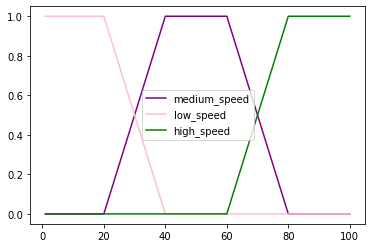

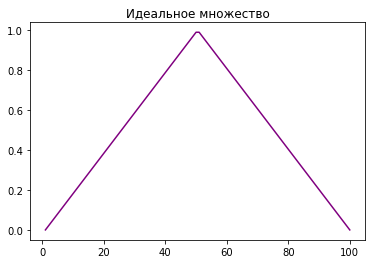

{30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0}
Высота=  1.0
Мощность=  59
Диапазон значений:  (21.0, 79.0)
Максимумы:  (40.0, 50.0, 60.0)
Центр тяжести=  50.0
Момент инерции=  6660.0
Размытость: 
Энтропийная мера=  (14.355046155633588, 0.28710092311267177)
Альтернатива 1 (линейная)=  0.2
Альтернатива 2 (квадратичная)=  0.3660601043544625
FS moment PR1: 10660.0
FS moment PR2: 6660.0
FS moment PR3 10660.0


In [4]:
Spr = np.arange (1, 101, 1)
Pr1 = triangle_FS(Spr, a=20, b=40, c=60, d=80)
Pr2 = triangle_FS(Spr, a=20, b=40, c=60, d=80, form='less')
Pr3 = triangle_FS(Spr, a=20, b=40, c=60, d=80, form='greater')
FS_plot([Pr1, Pr2, Pr3], labels=['medium_speed', 'low_speed', 'high_speed'])

Pr4 = triangle_FS (Spr)
FS_plot([Pr4], title=u'Идеальное множество')

print (alpha_srez (Pr1, alpha=0.5))
r = FS_describe(Pr1)
print ('FS moment PR1:', FS_moment (Pr1, r[3][0]))
print ('FS moment PR2:', FS_moment (Pr1, r[3][1]))
print ('FS moment PR3', FS_moment (Pr1, r[3][2]))

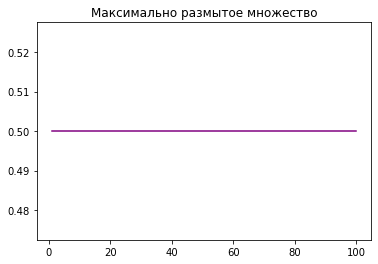

Высота=  0.5
Мощность=  100
Диапазон значений:  (1.0, 100.0)
Максимумы:  (1.0, 50.5, 100.0)
Центр тяжести=  50.5
Момент инерции=  41662.5
Размытость: 
Энтропийная мера=  (50.0, 1.0)
Альтернатива 1 (линейная)=  1.0
Альтернатива 2 (квадратичная)=  1.0


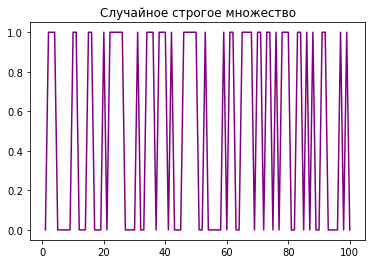

Высота=  1
Мощность=  50
Диапазон значений:  (2, 99)
Максимумы:  (2, 51.16, 99)
Центр тяжести=  51.16
Момент инерции=  37486.72
Размытость: 
Энтропийная мера=  (-0.0, -0.0)
Альтернатива 1 (линейная)=  0.0
Альтернатива 2 (квадратичная)=  0.0


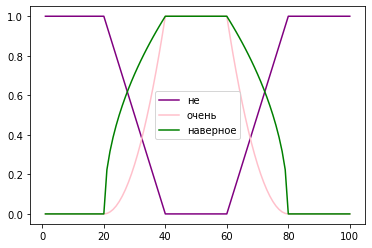

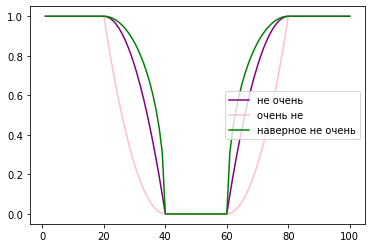

In [5]:
D_pr1 = triangle_FS(Spr, b=0, c=100, h=0.5)
FS_plot([D_pr1], title = u'Максимально размытое множество', name='p6')
r=FS_describe(D_pr1)

D_pr2 = dict()
for el in Spr:
    D_pr2[el] = np.random.randint(2)
FS_plot([D_pr2], title = u'Случайное строгое множество', name='p6')
r=FS_describe(D_pr2)

quants=[[u'не'], [u'очень'], [u'наверное']]
labels=[u'не', u'очень', u'наверное']
FS_plot([FS_quantificator(Pr1, quantificators=x) for x in quants], labels=labels)

quants=[[u'не', u'очень'], [u'очень', u'не'], [u'наверное', u'не', u'очень']]
labels=[u'не очень', u'очень не', u'наверное не очень']
FS_plot([FS_quantificator(Pr1, quantificators=x) for x in quants], labels=labels)

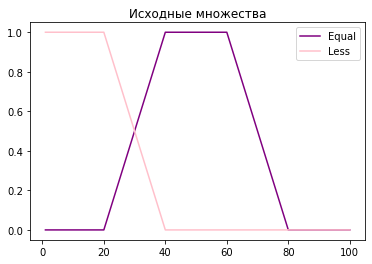

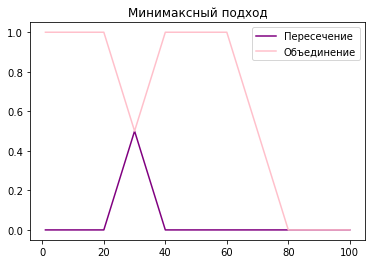

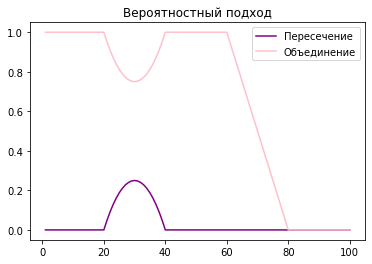

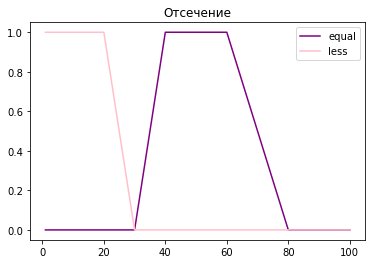

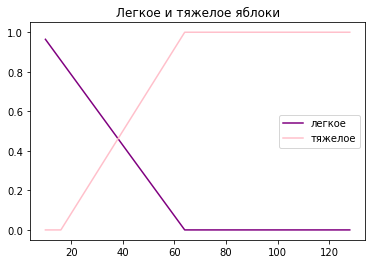

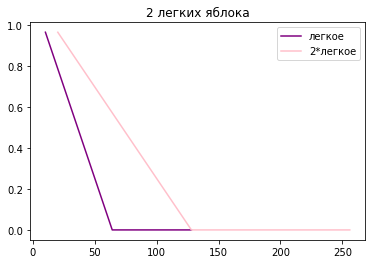

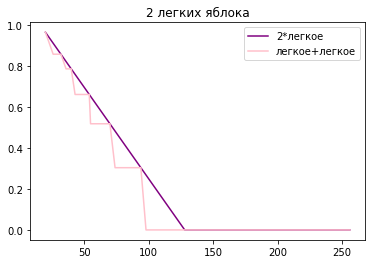

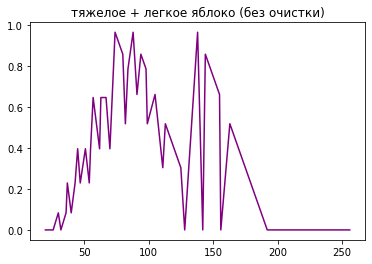

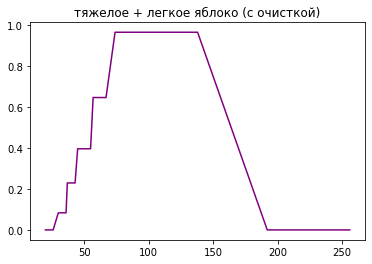

In [8]:
FS_plot([Pr1, Pr2], labels=[u'Equal', u'Less'], title=u'Исходные множества')
FS_plot([FS_intersection([Pr1,Pr2], Ps=[1,1], method='minmax'), FS_union([Pr1,Pr2], Ps=[1,1], method='minmax')], labels=[u'Пересечение', u'Объединение'], title=u'Минимаксный подход')
FS_plot([FS_intersection([Pr1,Pr2], Ps=[1,1], method='probability'), FS_union([Pr1,Pr2], Ps=[1,1], method='probability')], labels=[u'Пересечение', u'Объединение'], title=u'Вероятностный подход')

a = FS_otsechenie([Pr1,Pr2], Ps=[1,1], method='minmax')
b = FS_otsechenie([Pr2,Pr1], Ps=[1,1], method='minmax')

FS_plot([a,b], labels=[u'equal', u'less'], title=u'Отсечение')

'''
p=0.4
otv1=FS_union([Pr1,Pr2], Ps=[p,1-p], method='minmax')
otv2=FS_union([Pr1,Pr2], Ps=[p,1-p], method='probability')
FS_plot([otv1, otv2], labels=[u'минимаксный', u'вероятностный'], title=u'Первая задача, p='+str(p))
'''

Apples=np.array([10., 16., 20., 27., 35., 47., 64., 78., 128.]) #вес в граммах
l_Apples=triangle_FS(Apples, b=8., d=64., h=1, form='equal')
h_Apples=triangle_FS(Apples, b=16., d=64., h=1, form='greater')
FS_plot([l_Apples, h_Apples], labels=[u'легкое', u'тяжелое'], title=u'Легкое и тяжелое яблоки')

l2_Apples=FS_arifm_operation_Num(l_Apples, 2, Func= lambda x,y: x*y)
FS_plot([l_Apples, l2_Apples], labels=[u'легкое', u'2*легкое'], title=u'2 легких яблока')


l21_Apples=FS_arifm_operation_Set(l_Apples, l_Apples, clearing=True)
FS_plot([l2_Apples, l21_Apples], labels=[u'2*легкое', u'легкое+легкое'], title=u'2 легких яблока')

lh_Apples=FS_arifm_operation_Set(l_Apples, h_Apples)
FS_plot([lh_Apples], title=u'тяжелое + легкое яблоко (без очистки)')

lhc_Apples=FS_arifm_operation_Set(l_Apples, h_Apples, clearing=True)
FS_plot([lhc_Apples], title=u'тяжелое + легкое яблоко (с очисткой)')

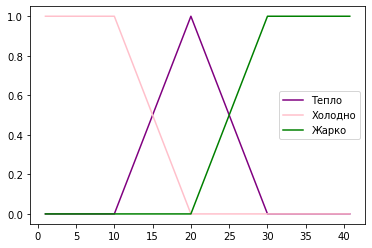

In [9]:
'''
Нечеткий вывод
'''

Stemp = np.arange(1, 41, 0.25)
Teplo=triangle_FS(Stemp, a=10, b=20, d=30)
Holodno=triangle_FS(Stemp, a=10, b=20, d=30, form='less')
Zharko=triangle_FS(Stemp, a=10, b=20, d=30, form='greater')
FS_plot([Teplo, Holodno, Zharko], labels=[u'Тепло', u'Холодно', u'Жарко'] )

def FS_func(FSx, Uy, Func=lambda x,Ux,Uy: np.array([1]*len(Uy)), method='minmax'):
    masx=list(FSx.items())
    Ux=np.array(masx).T[0]
    masmu=np.array([0]*len(Uy))
    if method=='minmax':
        for el in Ux:
            masmu=np.max([masmu, np.min([Func(el, Ux, Uy), [FSx[el]] * len(Uy)], axis=0)], axis=0)
    elif method == 'probability':
         for el in Ux:
            mm=Func(el, masx, Uy) * FSx[el]
            masmu = masmu+mm-masmu*mm
    else:
        print ('Неизвестный метод', method)
    return dict (np.array([Uy, masmu]).T)

def FS_f(x, Ux, Uy):
    minx = np.min(Ux)
    miny = np.min(Uy)
    maxy = np.max(Uy)
    k= float(x-minx)/float(Ux.max()-minx)
    gran=k*(maxy-miny)+miny

    arr1 = np.array([], 'float64')
    for y in Uy:
        if (y == gran):
            arr1 = np.append(arr1, 1.)
        elif y < gran:
            arr1 = np.append(arr1, float(y - miny) / (gran - miny))
        else:
            arr1 = np.append(arr1, float(maxy - y) / (maxy - gran))
    return arr1

#Oboroti = np.arange(100, 2001, 10)
#FS_plot([FS_func(Holodno, Oboroti, Func=FS_f), FS_func(Teplo, Oboroti, Func=FS_f), FS_func(Zharko, Oboroti, Func=FS_f)], labels=[u'Холодно', u'Тепло', u'Жарко'], title=u'Обороты вентилятора при')

quants = [[u'не'],[u'очень'],[u'наверное']]

#FS_plot( [FS_quantificator(Teplo, quantificators=x) for x in quants],labels=[u'не',u'очень',u'наверное'], title=u'тепло')

#FS_plot( [FS_func(FS_quantificator(Teplo, quantificators=x), Oboroti, Func=FS_f) for x in quants], labels=[u'не',u'очень',u'наверное'], title=u'обороты вентилятора при тепло')

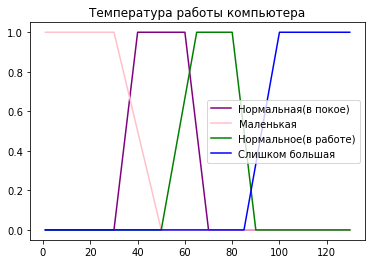

In [10]:
Stemp = np.arange(1, 130, 0.25)
Norm = triangle_FS(Stemp, a=30, b=40, c=60, d=70)
Cold = triangle_FS(Stemp, a=30, b=50, d=30, form='less')
Hot = triangle_FS(Stemp, a=50, b=65, c=80, d=90)
Too_hot = triangle_FS(Stemp, b=85, d=100, form='greater')
FS_plot([Norm, Cold, Hot, Too_hot], labels=[u'Нормальная(в покое)', u'Маленькая', u'Нормальное(в работе)', u'Слишком большая'], 
        title=u'Температура работы компьютера')

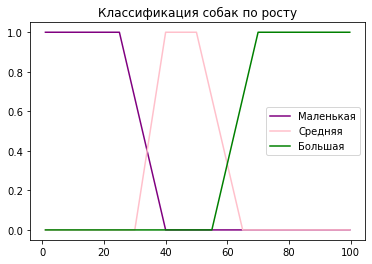

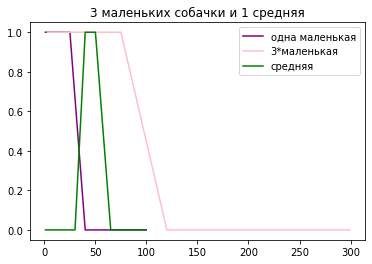

In [11]:
stemp = np.arange(1, 100, 0.25)
small = triangle_FS(stemp, a=25, b=40, form='less')
medium = triangle_FS(stemp, a=30, b=40, c=50, d=65)
large = triangle_FS(stemp, b=55, d=70, form='greater')
FS_plot([small, medium, large], labels=[u'Маленькая', u'Средняя', u'Большая'], title=u'Классификация собак по росту')

small3 = FS_arifm_operation_Num(small, 3, Func= lambda x,y: x*y)
FS_plot([small,small3,medium], labels=[u'одна маленькая', u'3*маленькая', u'средняя'], title=u'3 маленьких собачки и 1 средняя')

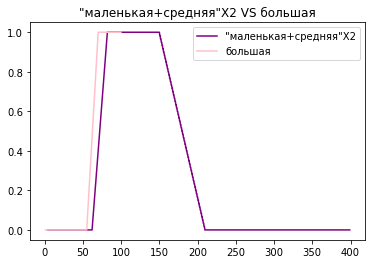

In [12]:
sm = FS_arifm_operation_Set(small, medium, clearing=True)
sm2 = FS_arifm_operation_Num(sm, 2, Func= lambda x,y: x*y)

FS_plot([sm2, large], labels=[u'"маленькая+средняя"Х2', u'большая'], title=u'"маленькая+средняя"Х2 VS большая')

Маленькая и средняя почти совпадают с большой

Нечеткие правила работы:
Если в машине очень мало бензина - далеко не уедем
Если в машине половина бака - уедем на расстояние средней дальности
Если в машине полный бак - уедем далеко

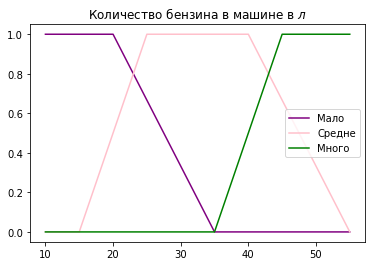

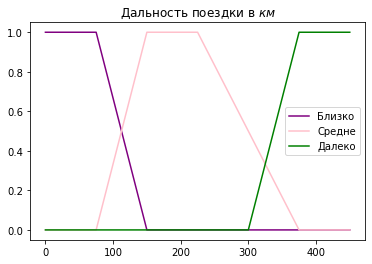

In [13]:
benzin = np.arange(10, 60, 5)
malo = triangle_FS(benzin, a=20, b=35, form='less')
sredne = triangle_FS(benzin, a=15, b=25, c=40, d=55)
mnogo = triangle_FS(benzin, b=35, d=45, form='greater')
FS_plot([malo, sredne, mnogo], labels=[u'Мало', u'Средне', u'Много'], title=u'Количество бензина в машине в $л$')

rasst = np.arange(0, 500, 75)
blizko = triangle_FS(rasst, a=75, b=125, form='less')
srednenko = triangle_FS(rasst, a=100, b=115, c=275, d=325)
daleko = triangle_FS(rasst, b=315, d=375, form='greater')
FS_plot([blizko, srednenko, daleko], labels=[u'Близко', u'Средне', u'Далеко'], title=u'Дальность поездки в $км$')

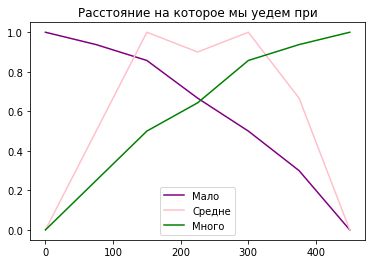

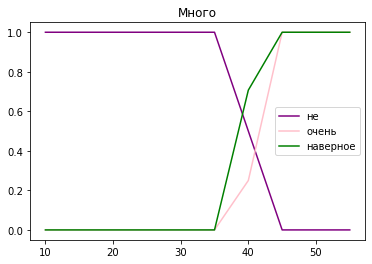

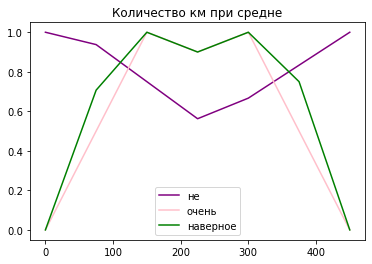

In [14]:
FS_plot([FS_func(malo, rasst, Func=FS_f), FS_func(sredne, rasst, Func=FS_f), FS_func(mnogo, rasst, Func=FS_f)], 
        labels=[u'Мало', u'Средне', u'Много'], title=u'Расстояние на которое мы уедем при')

quants = [[u'не'],[u'очень'],[u'наверное']]

FS_plot( [FS_quantificator(mnogo, quantificators=x) for x in quants], 
        labels=[u'не',u'очень',u'наверное'], title=u'Много')

FS_plot( [FS_func(FS_quantificator(sredne, quantificators=x), rasst, Func=FS_f) for x in quants], 
        labels=[u'не',u'очень',u'наверное'], title=u'Количество км при средне')

Обозначим помещение - зал 50 кв. м. с 20 батареями и 10 увлажнителями

если в помещении мало работающих батарей и работают увлажнители - то влажно
если в помещении среднее количество батарей - то средне
если в помещении много работающих или увлажнители не работают - то сухо

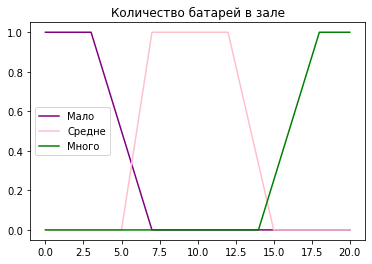

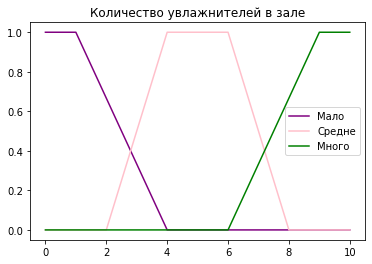

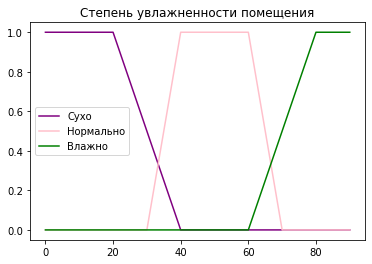

In [15]:
batarei = np.arange(0,21,1)
malo_bat = triangle_FS(batarei, a=3, b=7, form='less')
norm_bat = triangle_FS(batarei, a=5, b=7, c=12, d=15)
mnogo_bat = triangle_FS(batarei, b=14, d=18, form='greater')

FS_plot([malo_bat, norm_bat, mnogo_bat], labels=[u'Мало', u'Средне', u'Много'], 
        title=u'Количество батарей в зале')


uvlag = np.arange(0,11,1)
malo_uvlag = triangle_FS(uvlag, a=1, b=4, form='less')
norm_uvlag = triangle_FS(uvlag, a=2, b=4, c=6, d=8)
mnogo_uvlag = triangle_FS(uvlag, b=6, d=9, form='greater')

FS_plot([malo_uvlag, norm_uvlag, mnogo_uvlag], labels=[u'Мало', u'Средне', u'Много'], 
        title=u'Количество увлажнителей в зале')


vlagnost = np.arange(0,100,10)
cuxo = triangle_FS(vlagnost, a=20, b=40, form='less')
norm = triangle_FS(vlagnost, a=30, b=40, c=60, d=70)
vlagno = triangle_FS(vlagnost, b=60, d=80, form='greater')

FS_plot([cuxo, norm, vlagno], labels=[u'Сухо', u'Нормально', u'Влажно'], 
        title=u'Степень увлажненности помещения')

Степень уверенности, что выполняется правила: 
№1:0.6666666666666666, 
№2:0.0, 
№3:0


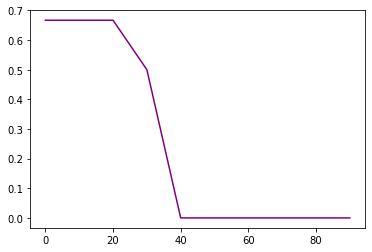

Высота=  0.6666666666666666
Мощность=  4
Диапазон значений:  (0.0, 30.0)
Максимумы:  (0.0, 10.0, 20.0)
Центр тяжести=  14.0
Момент инерции=  293.3333333333333
Размытость: 
Энтропийная мера=  (1.6699250014423126, 0.3339850002884625)
Альтернатива 1 (линейная)=  0.30000000000000004
Альтернатива 2 (квадратичная)=  0.483045891539648


In [16]:
b = 2
u = 8
pp1 = F_And([malo_bat.get(b), mnogo_uvlag.get(u)])
pp2 = norm_bat.get(b)
pp3 = F_Or([mnogo_bat.get(b), malo_uvlag.get(u)])

print(f'''Степень уверенности, что выполняется правила: 
№1:{pp1}, 
№2:{pp2}, 
№3:{pp3}''')

res_minmax = FS_union([cuxo, norm, vlagno], Ps=[pp1,pp2,pp3])
FS_plot([res_minmax])
r = FS_describe(res_minmax)

0.6666666666666666 0.0 0


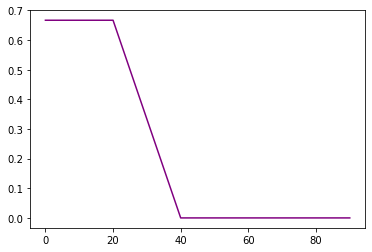

Высота=  0.6666666666666666
Мощность=  4
Диапазон значений:  (0.0, 30.0)
Максимумы:  (0.0, 10.0, 20.0)
Центр тяжести=  12.857142857142856
Момент инерции=  247.6190476190476
Размытость: 
Энтропийная мера=  (1.6982458350160314, 0.3396491670032063)
Альтернатива 1 (линейная)=  0.26666666666666666
Альтернатива 2 (квадратичная)=  0.42163702135578396


In [17]:
b = 2
u = 8
pp1 = F_And([malo_bat.get(b), mnogo_uvlag.get(u)],method='probability')
pp2 = norm_bat.get(b)
pp3 = F_Or([mnogo_bat.get(b), malo_uvlag.get(u)],method='probability')

print(pp1,pp2,pp3)

res_prob = FS_union([cuxo, norm, vlagno], Ps=[pp1,pp2,pp3],method='probability')
FS_plot([res_prob])
r = FS_describe(res_prob)

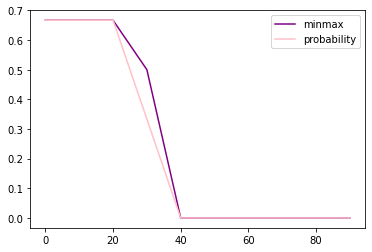

In [18]:
FS_plot([res_minmax, res_prob], labels=[u'minmax', u'probability'])